In [6]:
# standard imports
import pandas as pd
import numpy as np
import math

# prepare + acquire
from acquire_b import get_zillow_data
import prepare_b
from sklearn.model_selection import train_test_split

# exploration / visualization
import seaborn as sns
import matplotlib.pyplot as plt

# hypotheses testing
import scipy.stats as stats

# modeling
from final_files import model_b
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Acquire

In [7]:
# use the function to grab the data from SQL
zillow = get_zillow_data()
zillow.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,parcelid.1,logerror,transactiondate,propertylandusetypeid.1,propertylandusedesc
0,1248,17305333,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,212.46,NaN,NaN,6.111002e+13,1248,11289917,-0.362001,2017-06-23,263,Mobile Home
1,1772,10838338,NaN,NaN,NaN,2.0,4.0,NaN,6.0,2.0,...,6089.82,NaN,NaN,6.037128e+13,1772,11705026,-0.146056,2017-06-30,261,Single Family Residential
2,2028,10901531,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6679.55,NaN,NaN,6.037125e+13,2028,14269464,0.021085,2017-06-01,261,Single Family Residential
3,3273,11262089,1.0,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,3876.31,NaN,NaN,6.037901e+13,3273,11389003,-0.325393,2017-06-01,261,Single Family Residential
4,3429,11323134,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,...,4206.15,NaN,NaN,6.037901e+13,3429,11967869,-0.005566,2017-06-29,261,Single Family Residential


In [8]:
# summarize
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19667 entries, 0 to 19666
Data columns (total 65 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            19667 non-null  int64  
 1   parcelid                      19667 non-null  int64  
 2   airconditioningtypeid         5759 non-null   float64
 3   architecturalstyletypeid      28 non-null     float64
 4   basementsqft                  5 non-null      float64
 5   bathroomcnt                   19667 non-null  float64
 6   bedroomcnt                    19667 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         14715 non-null  float64
 9   calculatedbathnbr             19292 non-null  float64
 10  decktypeid                    85 non-null     float64
 11  finishedfloor1squarefeet      961 non-null    float64
 12  calculatedfinishedsquarefeet  19505 non-null  float64
 13  f

**Takeaways**
- there are way too many variables
- data needs to be filtered to relevant features
- there is a ton of null values
- we can try to keep any column with 19000+ observations
- the missing values can be dropped or imputed 

---
# Prepare

In [9]:
# create a dataframe from prepare file
df = prepare_b.prep_zillow()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18631 entries, 1 to 19666
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fullbathcnt  18631 non-null  float64
 1   bathroomcnt  18631 non-null  float64
 2   bedroomcnt   18631 non-null  int64  
 3   zipcode      18631 non-null  int64  
 4   taxamount    18631 non-null  float64
 5   home_value   18631 non-null  float64
 6   yearbuilt    18631 non-null  int64  
 7   sqft         18631 non-null  int64  
 8   county       18631 non-null  object 
 9   tax_rate     18631 non-null  float64
dtypes: float64(5), int64(4), object(1)
memory usage: 1.6+ MB


In [10]:
# look into the numerical data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fullbathcnt,18631.0,2.083356,0.779486,1.00,2.00,2.00,3.00,4.00
bathroomcnt,18631.0,2.123450,0.792445,1.00,2.00,2.00,3.00,4.50
bedroomcnt,18631.0,3.013311,0.899833,0.00,2.00,3.00,4.00,5.00
zipcode,18631.0,96499.725672,3867.263859,95982.00,96159.00,96341.00,96940.00,399675.00
taxamount,18631.0,4923.589798,4924.892356,49.18,2449.50,3872.02,5944.69,176576.49
home_value,18631.0,398938.170791,421859.174519,11517.00,181390.00,305985.00,489257.50,14721125.00
yearbuilt,18631.0,1962.017981,22.578220,1862.00,1949.00,1960.00,1979.00,2015.00
sqft,18631.0,1653.741184,702.535681,215.00,1170.50,1497.00,1966.00,8243.00
tax_rate,18631.0,1.323912,0.354132,0.03,1.19,1.24,1.36,15.51


In [11]:
# Use split function to create train, validate, and test dfs
train, validate, test = prepare_b.zillow_split(df)

train.shape, validate.shape, test.shape

((10432, 10), (4472, 10), (3727, 10))

In [12]:
# Use function to add scaled columns to dataframe
# train, validate, test = prepare_b.add_scaled_columns(train, validate, test, scaler, 
                                           #train.drop(columns=['taxvaluedollarcnt', 'county', 'zipcode']).columns)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10432 entries, 2018 to 6553
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fullbathcnt  10432 non-null  float64
 1   bathroomcnt  10432 non-null  float64
 2   bedroomcnt   10432 non-null  int64  
 3   zipcode      10432 non-null  int64  
 4   taxamount    10432 non-null  float64
 5   home_value   10432 non-null  float64
 6   yearbuilt    10432 non-null  int64  
 7   sqft         10432 non-null  int64  
 8   county       10432 non-null  object 
 9   tax_rate     10432 non-null  float64
dtypes: float64(5), int64(4), object(1)
memory usage: 896.5+ KB


**takeaways**: 
- prepare_b.py
    - `fips_labels(x)` function
        - change the id values in `fips` to the county name
    - `prep_zillow(cached)` function
        - acquire zillow data
        - filter columns to use
        - drop null values
        - change categorical columns to integers
        - rename columns for readability
            - `regionidzip` $\rightarrow$ `zipcode`
            - `calculatedfinishedsquarefeet` $\rightarrow$ `sqft`
            - `taxvaluedollarcnt` $\rightarrow$ `home_value`
        - add `county` column
        - create `tax_rate` feature = $\frac{taxamount}{taxvaluedollaramt}$
        - drop `fips` column
        - dropped rows with more then 5 bedrooms, 4 bathrooms 
    - `zillow_split(df)` function
        - split into train, validate, test datasets
    - `add_scaled_columns(train, validate, test, scaler, columns_to_scale)`
        - add scaled columns for continuous variables to all datasets as a dataframe

---
# Exploration

In [13]:
# plt rc sets defaults for matplotlib figures
plt.rc("font", size=13)
plt.rc("figure", figsize= (13,7))

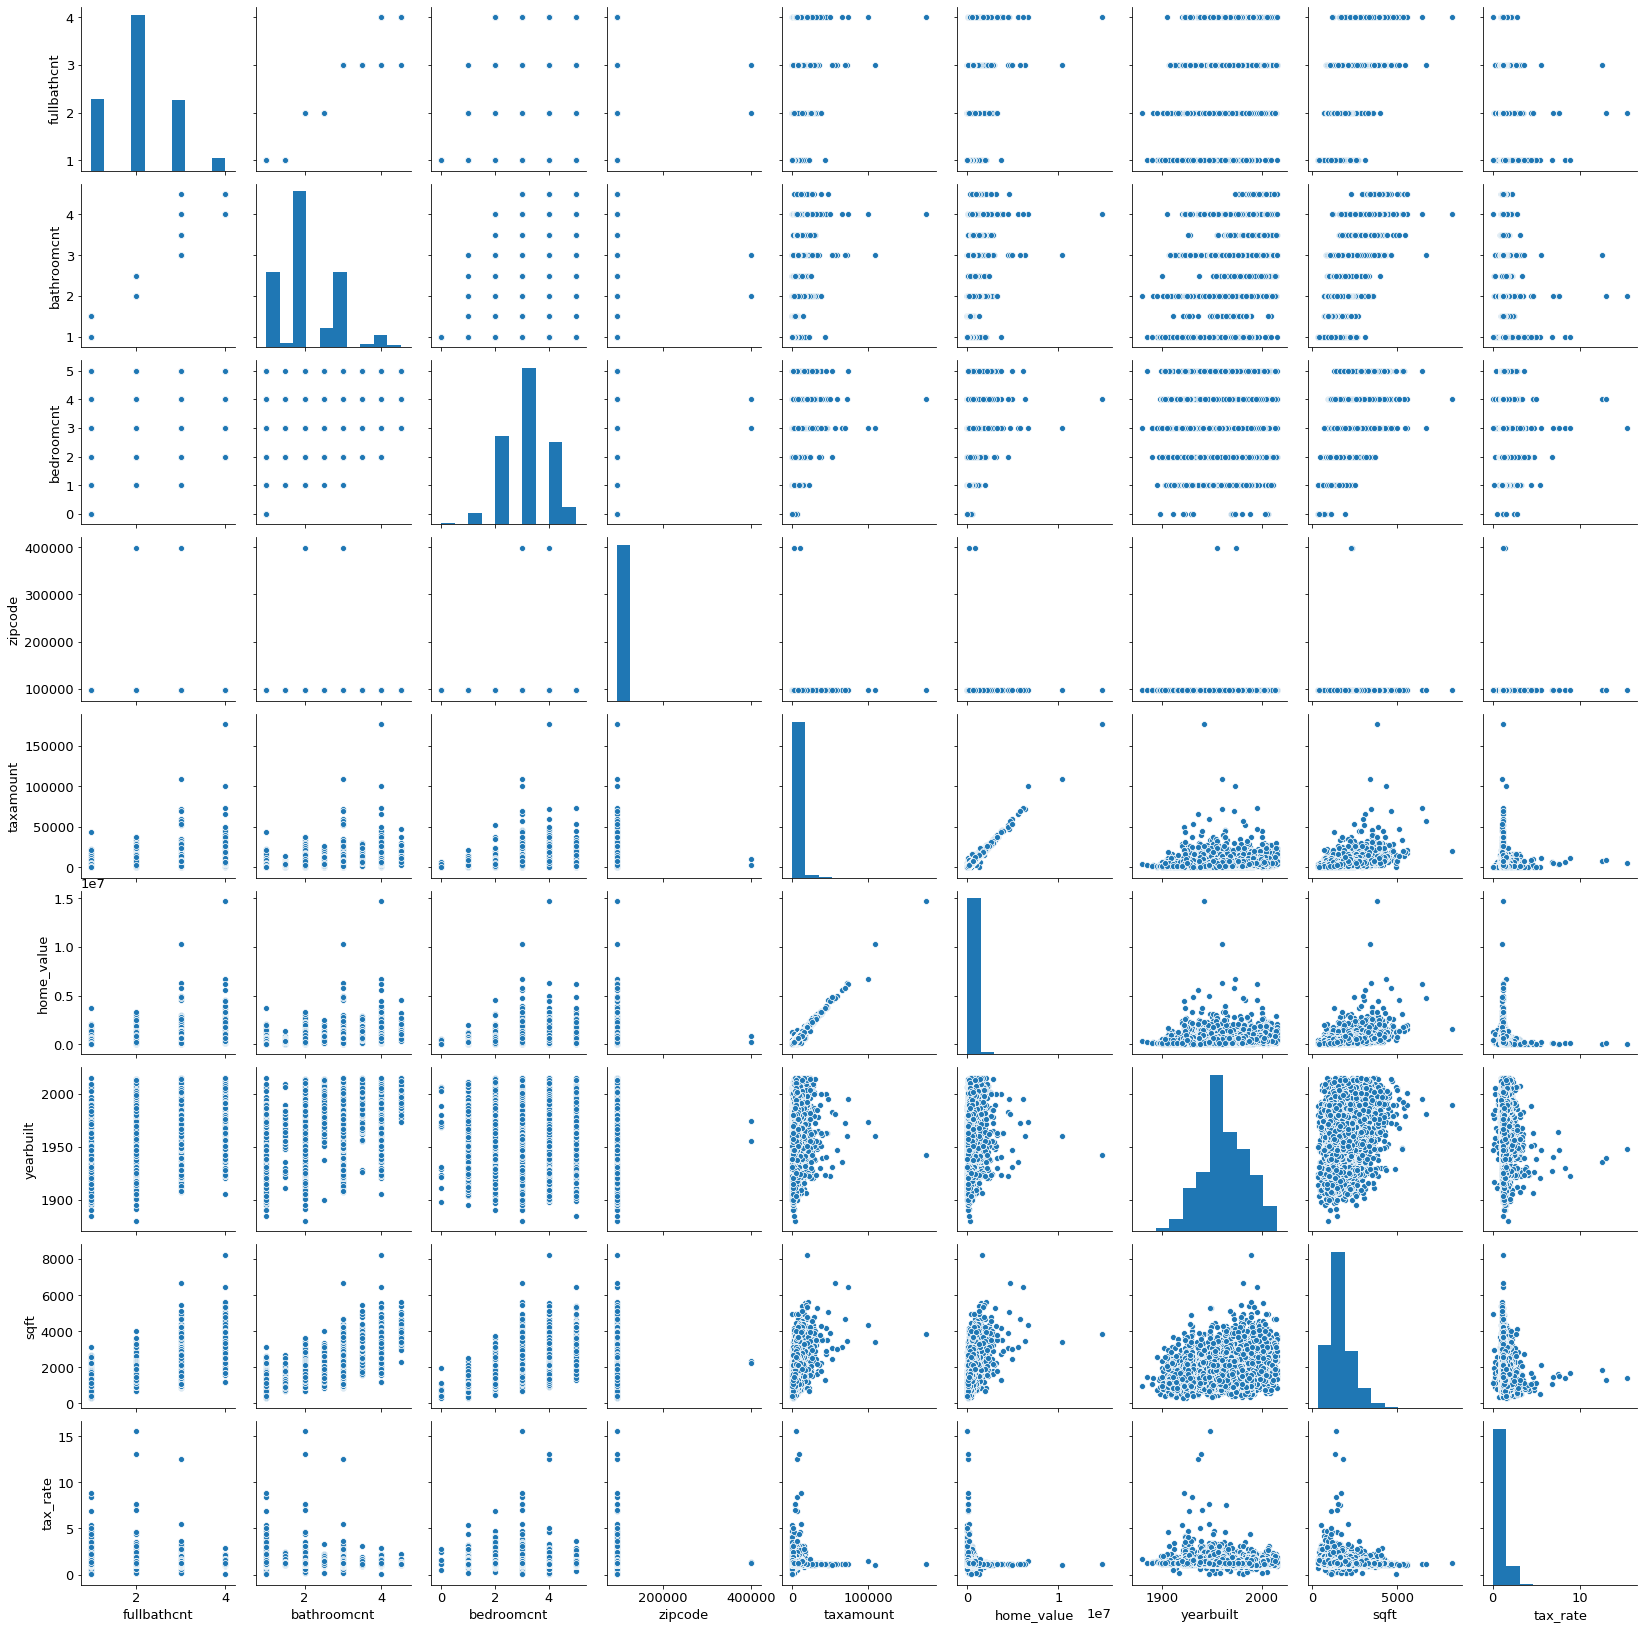

In [14]:
# Visualize all variable relationships
sns.pairplot(train)

In [15]:
# look into numerical stats data again
train.describe().T

,count,mean,std,min,25%,50%,75%,max
fullbathcnt,10432.0,2.079084,0.784017,1.00,2.00,2.00,3.0000,4.00
bathroomcnt,10432.0,2.119824,0.796901,1.00,2.00,2.00,3.0000,4.50
bedroomcnt,10432.0,3.009298,0.903455,0.00,2.00,3.00,4.0000,5.00
zipcode,10432.0,96507.108800,4216.427448,95982.00,96152.00,96341.00,96533.0000,399675.00
taxamount,10432.0,4920.602837,4847.131771,125.95,2449.62,3869.05,5961.0175,176576.49
home_value,10432.0,398323.513516,416466.790032,11517.00,181420.25,306487.50,492395.0000,14721125.00
yearbuilt,10432.0,1962.065951,22.695220,1880.00,1949.00,1960.00,1979.0000,2015.00
sqft,10432.0,1654.419287,703.802884,320.00,1161.00,1488.00,1981.2500,8243.00
tax_rate,10432.0,1.328499,0.395834,0.03,1.19,1.24,1.3600,15.51


In [16]:
train.nunique()

fullbathcnt        4
bathroomcnt        8
bedroomcnt         6
zipcode          379
taxamount      10368
home_value      9416
yearbuilt        124
sqft            2654
county             3
tax_rate         265
dtype: int64

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 <a list of 9 Text xticklabel objects>)

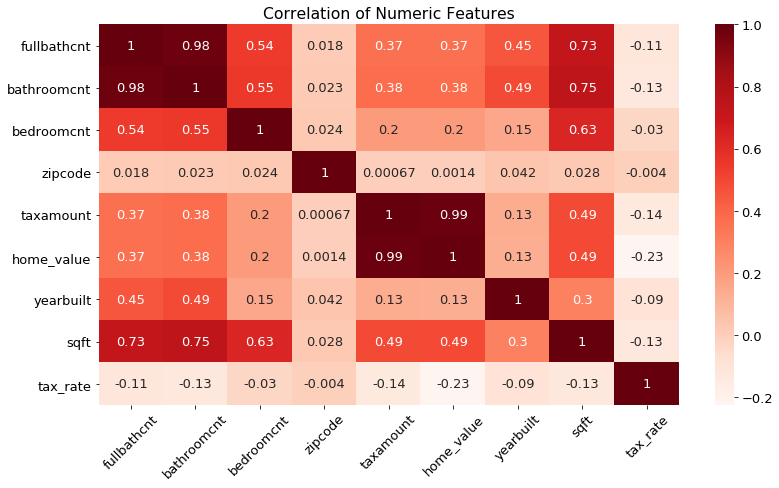

In [17]:
# looking at correlation for all variables
sns.heatmap(train.corr(), cmap='Reds', annot=True)
plt.title('Correlation of Numeric Features')
plt.xticks(rotation=45)

(0, 2000000)

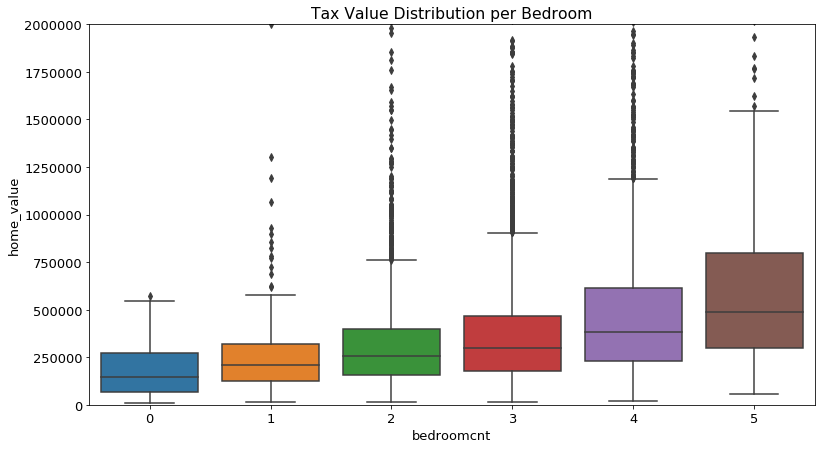

In [18]:
# visualize distribution with box plot
sns.boxplot(data=train, y='home_value', x='bedroomcnt')
plt.title('Tax Value Distribution per Bedroom')
plt.ylim(0, 2_000_000)

Text(0.5, 1.0, 'Tax Rate per County')

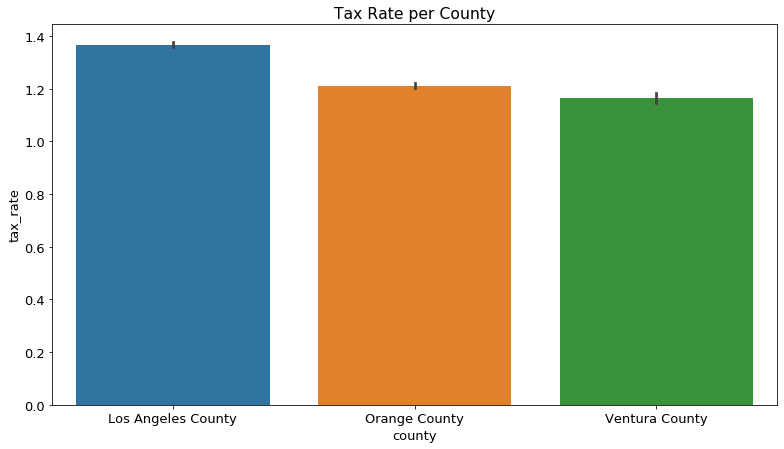

In [19]:
# visualize mean tax rate for each county
sns.barplot(data=train, y='tax_rate', x='county')
plt.title('Tax Rate per County')

Text(0.5, 1.0, 'Count of Single Unit Homes in each County')

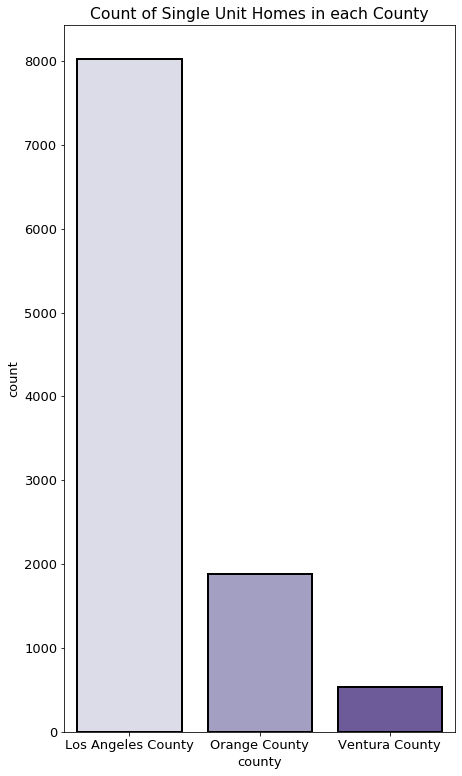

In [31]:
# visualize the number of single unit homes for each county
plt.rc("figure", figsize= (7,13))
sns.countplot(x = 'county', data=train, palette='Purples', ec='black', linewidth=2)
plt.title('Count of Single Unit Homes in each County')

In [ ]:
sns.swarmplot(data=train, x='county', y='home_value')

**takeaways**
- catgorical variables
    - `bedroomcnt`
    - `county`
- continuous variables
    - `bathroomcnt`
    - `taxamount`
    - `home_value`
    - `yearbuilt`
    - `sqft`
    - `county`
    - `tax_rate`
    
- there are several outliers in the data in terms of `home_value`
- `tax_rate` seems to be higher in LA County
- LA county has a lot more homes than anywhere else

___
## Hypothesis Tests

Does LA County have a higher average tax rate than the overall population?

### One Sample Single-Tailed T-Test

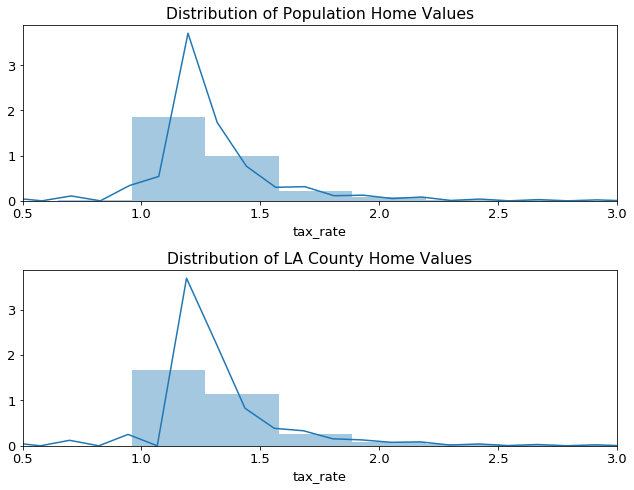

In [40]:
#plt.hist(train.tax_rate)
plt.rc("figure", figsize= (9,7))
plt.subplot(211)
sns.distplot(train.tax_rate)
plt.title('Distribution of Population Home Values')
plt.xlim(.5,3)

plt.subplot(212)
sns.distplot(train[train.county == 'Los Angeles County'].tax_rate)
plt.title('Distribution of LA County Home Values')
plt.xlim(.5, 3)
plt.tight_layout()

**Hypotheses**

$H_0$: mean tax rate Los Angeles County <= the overall population of assessed counties

$H_a$: mean tax rate Los Angeles County > the overall population of assessed counties

In [43]:
null_ost = 'the mean tax rate Los Angeles County <= the overall population of assessed counties'

# set a significance level
alpha = .05

# verify assumptions
train.county.value_counts()

Los Angeles County    8026
Orange County         1877
Ventura County         529
Name: county, dtype: int64

**Compute T-Statistic and P-Value**

In [44]:
overall_mean = train.tax_rate.mean()
sample_mean = train.tax_rate[train.county == 'Los Angeles County']

t, p = stats.ttest_1samp(sample_mean, overall_mean)
print('T-statistic: ', t)
print('P-value: ', p/2)

T-statistic:  7.984632930779852
P-value:  8.024468316734068e-16


**Decision**

In [45]:
if p/2 > alpha:
    print("We fail to reject H_0 that", null_ost)
elif t < 0:
    print("We fail to reject H_0 that", null_ost)
else:
    print("We reject H_0 that", null_ost)

We reject H_0 that the mean tax rate Los Angeles County <= the overall population of assessed counties


---
### Correlation Test

Is there a linear relationship between square footage and home value?

Text(0.5, 1.0, 'Square Footage and Home Value Relationship')

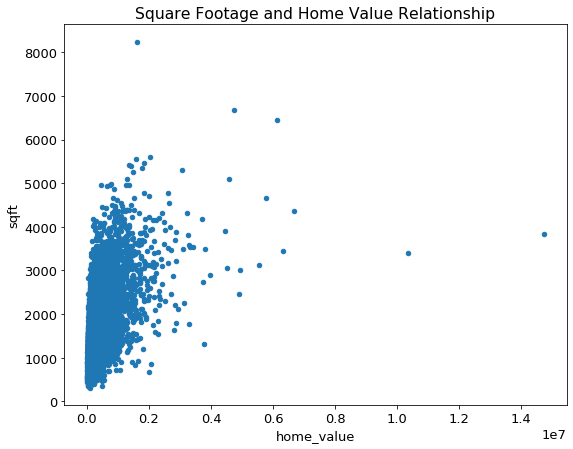

In [51]:
train.plot.scatter(y='sqft', x='home_value')
plt.title('Square Footage and Home Value Relationship')

**Hypotheses**

$H_0$: There is no linear relationship between square footage and home value

$H_a$: There is a linear relationship between square footage and home value

In [55]:
null_ct = 'there is no linear relationship between square footage and home value'

# set a significance level
alpha = .05

x = train.home_value
y = train.sqft

**Compute T-Statistic and P-Value**

In [56]:
r, p = stats.pearsonr(x, y)
print('r =', r)
print('p =', p)

r = 0.4931042422645457
p = 0.0


**Decision**

In [57]:
if p > alpha:
    print("We fail to reject H_0 that", null_ct)
else:
    print("We reject H_0 that", null_ct)

We reject H_0 that there is no linear relationship between square footage and home value


**Takeaways**: 
- the mean `tax_rate` is greater in LA County than the population mean

- there is a decent linear relationship between `sqft` and `home_value`

# Modeling

### Scale

In [ ]:
# Split into X and y data frames

# dropping zipcode, and county since they are categorical
# and tax rate/tax amount because it was derived from 
# home_value (target variable)
columns_to_drop = ['zipcode', 'county', 'tax_rate', 'taxamount', 'home_value']
target = 'home_value'

X_train = train.drop(columns=columns_to_drop)
X_validate = validate.drop(columns=columns_to_drop)
X_test = test.drop(columns=columns_to_drop)

y_train = train[[target]]
y_validate = validate[[target]]
y_test = test[[target]]

In [ ]:
# scale the data using min_max_scale function in model_b.py
X_train_scaled, X_validate_scaled, X_test_scaled = model_b.min_max_scale(X_train, X_validate, X_test)
X_train_scaled.head()

### Feature Selection

#### Select K Best

In [ ]:
# select the top 2 features based on select k best in model_b.py
skb_var = model_b.select_kbest(X_train_scaled, y_train, 2)
skb_var

#### Recursive Feature Elimination

In [ ]:
# select the top 2 features based on RFE in model_b.py
rfe_var = model_b.rfe(X_train_scaled, y_train, 2)
rfe_var

In [ ]:
# Split into X and y data frames (BEST FEATURES - from RFE)

X_train_best = X_train_scaled[rfe_var]
X_validate_best = X_validate_scaled[rfe_var]
X_test_best = X_test_scaled[rfe_var]

In [ ]:
# Split into X and y data frames (BEST FEATURES - from SKB)

X_train_best2 = X_train_scaled[skb_var]
X_validate_best2 = X_validate_scaled[skb_var]
X_test_best2 = X_test_scaled[skb_var]

In [ ]:
X_train_best.head()

### Baseline

In [ ]:
# using the mean for home_value
np.mean(y_train)

In [ ]:
# establish baseline metrics for comparison
from sklearn.metrics import mean_squared_error
from math import sqrt

baseline_rmse = sqrt(mean_squared_error(y_train, np.full(y_train.shape[0], np.mean(y_train))))
baseline_rmse

### Linear Regression

In [ ]:
# fit the model
lm = LinearRegression(normalize=True)\
.fit(X_train_best, y_train)

# predict train observations
lm_pred = lm.predict(X_train_best)

# evaluate train: compute root mean squared error
lm_rmse = sqrt(mean_squared_error(y_train, lm_pred))
lm_rmse

In [ ]:
# validate

# predict validate observations
lm_pred_v = lm.predict(X_validate_best)

# evaluate validate: compute root mean squared error
lm_rmse_v = sqrt(mean_squared_error(y_validate, lm_pred_v))
lm_rmse_v

### LassoLars

In [ ]:
#train model
lars = LassoLars(alpha=0.1)\
.fit(X_train_best, y_train)

lars_pred = lars.predict(X_train_best)

lars_rmse = sqrt(mean_squared_error(y_train, lars_pred))
lars_rmse

In [ ]:
#validate model
lars_pred_v = lars.predict(X_validate_best)

lars_rmse_v = sqrt(mean_squared_error(y_validate, lars_pred_v))
lars_rmse_v

### PolynomialFeatures + LinearRegression (squared)

In [ ]:
# make the polynomial thing
pf = PolynomialFeatures(degree=2)

# fit and transform the thing
# to get a new set of features..which are the original features sqauared
X_train_squared = pf.fit_transform(X_train_best)
X_validate_squared = pf.transform(X_validate_best)

# feed that data into our linear model. 
# make the thing
lm_squared = LinearRegression()
lm_squared.fit(X_train_squared, y_train)

# predict training observervations
lm_squared_pred = lm_squared.predict(X_train_squared)

# Evaluate our training predictions
lm_squared_rmse = sqrt(mean_squared_error(y_train, lm_squared_pred))
lm_squared_rmse

In [ ]:
# validate

lm_squared_pred_v = lm_squared.predict(X_validate_squared)

lm_squared_rmse_v = sqrt(mean_squared_error(y_validate, lm_squared_pred_v))
lm_squared_rmse_v

In [ ]:
print("Baseline Mean: ", baseline_rmse)
print("Linear Model: ", lm_rmse)
print("LassoLars: ", lars_rmse)
print("*Polynomial, squared: ", lm_squared_rmse)

In [ ]:
# test
X_test_squared = pf.transform(X_test_best)

lm_squared_pred_t = lm_squared.predict(X_test_squared)

lm_squared_rmse_t = sqrt(mean_squared_error(y_test, lm_squared_pred_t))
lm_squared_rmse_t